## ROME - one model + obs

In [1]:
import xarray as xr
import numpy as np
import skimage.measure as skm
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)


from os.path import expanduser
home = expanduser("~")

In [2]:
models = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',       # 2
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # cannot concatanate files for rcp85 run
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]
model = models[0]


experiments = [
    'historical',
    # 'rcp85'
    ]
experiment = experiments[0]       

folder = home + '/Documents/data/cmip5/ds'
fileName = model + '_precip_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
precip = ds.precip*60*60*24
precip.attrs['units']= 'mm/day'

rome_options = [
    'rome',
    # 'rome_n'
    ]
rome_option = rome_options[0]

folder = home + '/Documents/data/cmip5/' + model
fileName = model + '_rome_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
rome = ds[rome_option]


obs = {'GPCP':True}
if obs['GPCP']:
    folder = home + '/Documents/data/obs/ds'
    fileName = 'GPCP_precip.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    precip_gpcp = ds.precip

    folder = home + '/Documents/data/obs/GPCP'
    fileName = 'GPCP_rome.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    rome_gpcp = ds[rome_option]

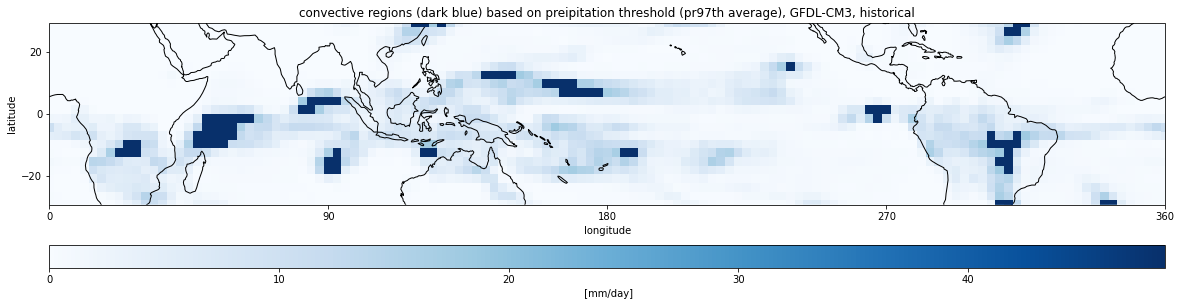

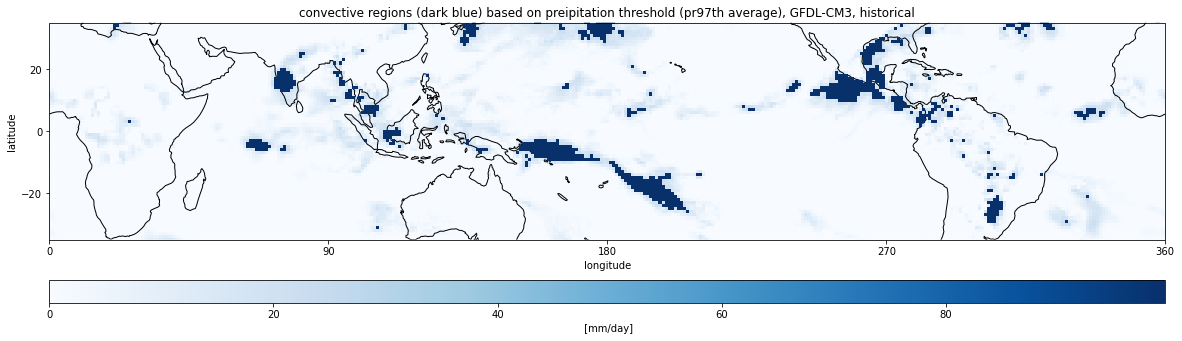

In [ ]:
fig= plt.figure(figsize=(20,7.5))
lat = precip.lat
lon = precip.lon
lonm,latm = np.meshgrid(lon,lat)

ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))

ax.add_feature(cfeat.COASTLINE)
ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())

day = 0
pr_day = precip.isel(time=day)
conv_threshold = precip.quantile(0.97,dim=('lat','lon')).mean(dim='time')

L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=np.nan,connectivity=2)
L = (L>0)*1
labelMatrix = xr.DataArray(
    data=L,
    dims=['lat', 'lon'],
    coords={'lat': pr_day.lat.data, 'lon': pr_day.lon.data}
    )

pcm= ax.pcolormesh(lonm,latm, pr_day,transform=ccrs.PlateCarree(),zorder=0, cmap='Blues')
ax.pcolormesh(lonm,latm, labelMatrix.where(labelMatrix>0),transform=ccrs.PlateCarree(),cmap='Blues_r')

ax.set_title('convective regions (dark blue) based on preipitation threshold (pr97th average), ' + model + ', ' + experiment)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_yticks([-20, 0, 20])
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_xticklabels([0, 90, 180, 270, 360])

plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = ' [mm/day]')


if obs['GPCP']:
    fig= plt.figure(figsize=(20,7.5))
    lat = precip_gpcp.lat
    lon = precip_gpcp.lon
    lonm,latm = np.meshgrid(lon,lat)

    ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))

    ax.add_feature(cfeat.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())

    day = 0
    pr_day = precip_gpcp.isel(time=day)
    conv_threshold = precip_gpcp.quantile(0.97,dim=('lat','lon')).mean(dim='time')

    L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=np.nan,connectivity=2)
    L = (L>0)*1
    labelMatrix = xr.DataArray(
        data=L,
        dims=['lat', 'lon'],
        coords={'lat': pr_day.lat.data, 'lon': pr_day.lon.data}
        )

    pcm= ax.pcolormesh(lonm,latm, pr_day,transform=ccrs.PlateCarree(),zorder=0, cmap='Blues')
    ax.pcolormesh(lonm,latm, labelMatrix.where(labelMatrix>0),transform=ccrs.PlateCarree(),cmap='Blues_r')

    ax.set_title('convective regions (dark blue) based on preipitation threshold (pr97th average), ' + model + ', ' + experiment)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')

    ax.set_yticks([-20, 0, 20])
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])

    plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = ' [mm/day]')

## annual

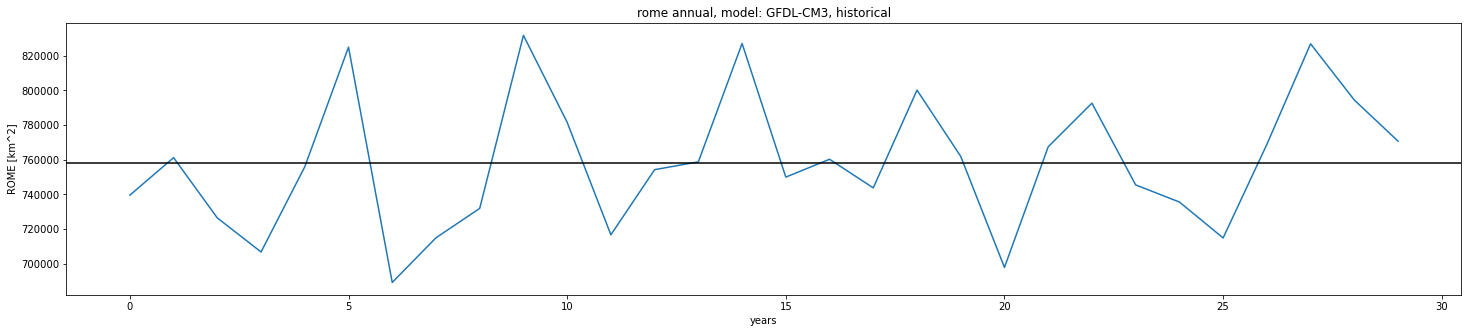

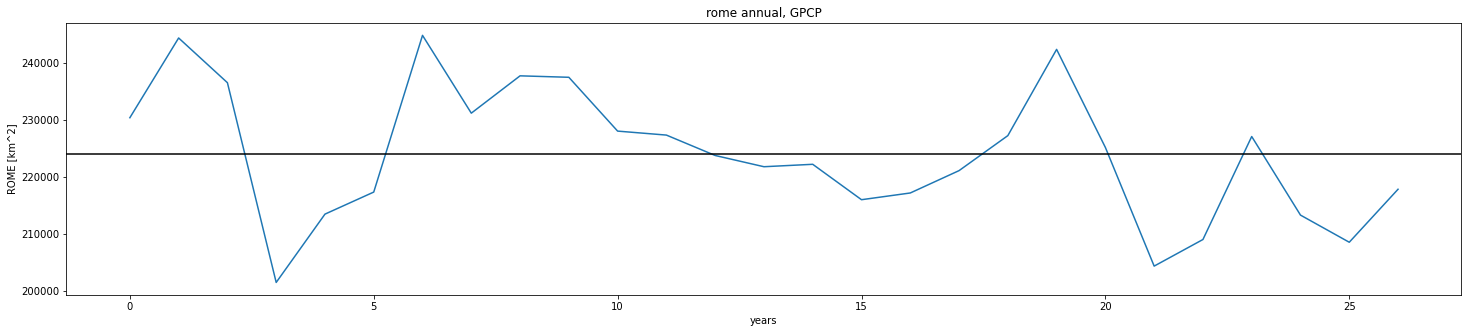

In [ ]:
plt.figure(figsize= (25,5))
plt.plot(rome.resample(time='Y').mean(dim='time'))
plt.title(rome_option + ' annual, model: ' + model + ', ' + experiment)
plt.ylabel(rome_option + ' [' + rome.units + ']')
plt.xlabel('years')
plt.axhline(y=rome.resample(time='Y').mean(dim='time').mean(dim='time'), color='k')


if obs['GPCP']:
    plt.figure(figsize= (25,5))
    plt.plot(rome_gpcp.resample(time='Y').mean(dim='time'))
    plt.title(rome_option + ' annual, GPCP')
    plt.ylabel(rome_option + ' [' + rome.units + ']')
    plt.xlabel('years')
    plt.axhline(y=rome_gpcp.resample(time='Y').mean(dim='time').mean(dim='time'), color='k')

In [ ]:
def to_monthly(da):
    year = da.time.dt.year
    month = da.time.dt.month

    # assign new coords
    da = da.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return da.set_index(time=("year", "month")).unstack("time")

## monthly


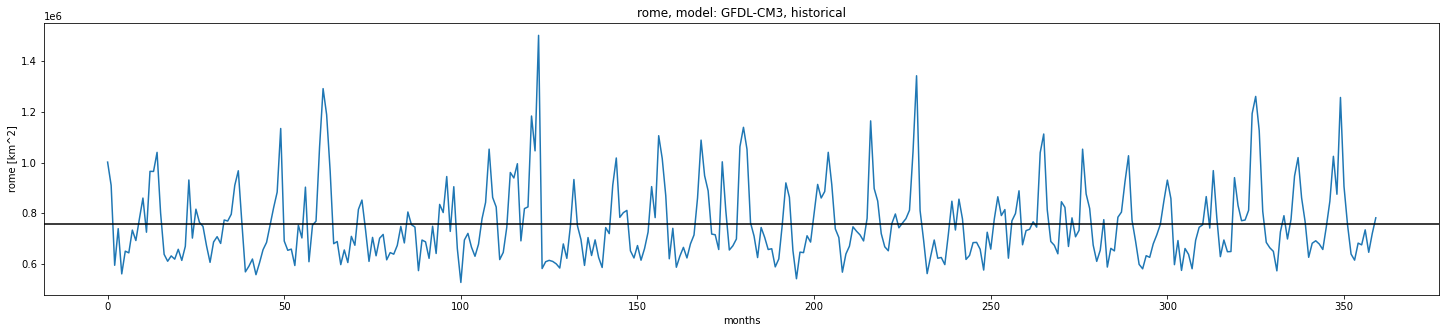

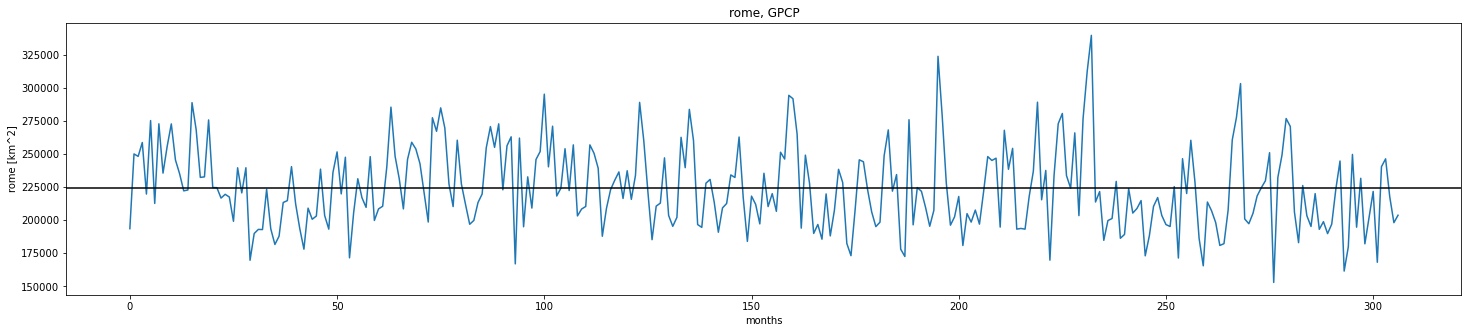

In [ ]:
plt.figure(figsize= (25,5))
plt.plot(rome.resample(time='M').mean(dim='time'))
plt.title(rome_option + ', model: ' + model + ', ' + experiment)
plt.ylabel(rome_option + ' [' + rome.units + ']')
plt.xlabel('months')
plt.axhline(y=rome.resample(time='M').mean(dim='time').mean(dim='time'), color='k')



if obs['GPCP']:
    plt.figure(figsize= (25,5))
    plt.plot(rome_gpcp.resample(time='M').mean(dim='time'))
    plt.title(rome_option + ', GPCP')
    plt.ylabel(rome_option + ' [' + rome.units + ']')
    plt.xlabel('months')
    plt.axhline(y=rome_gpcp.resample(time='M').mean(dim='time').mean(dim='time'), color='k')

## daily

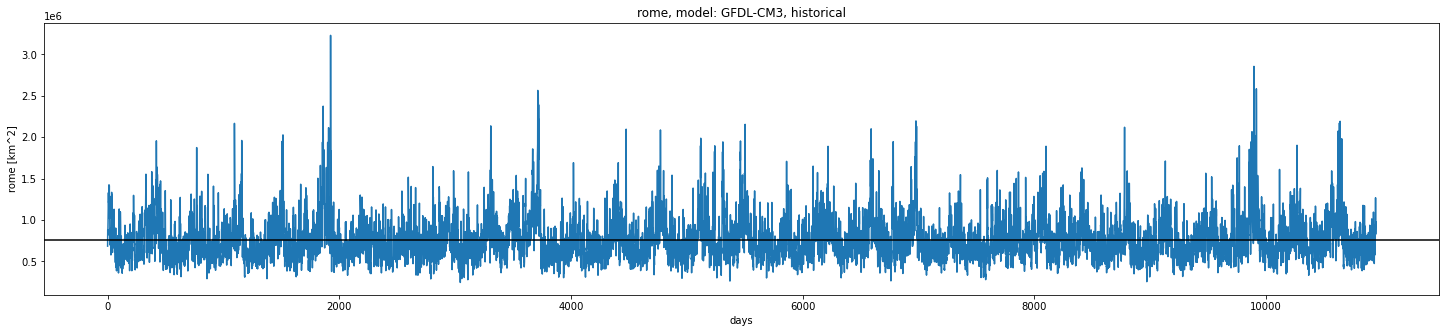

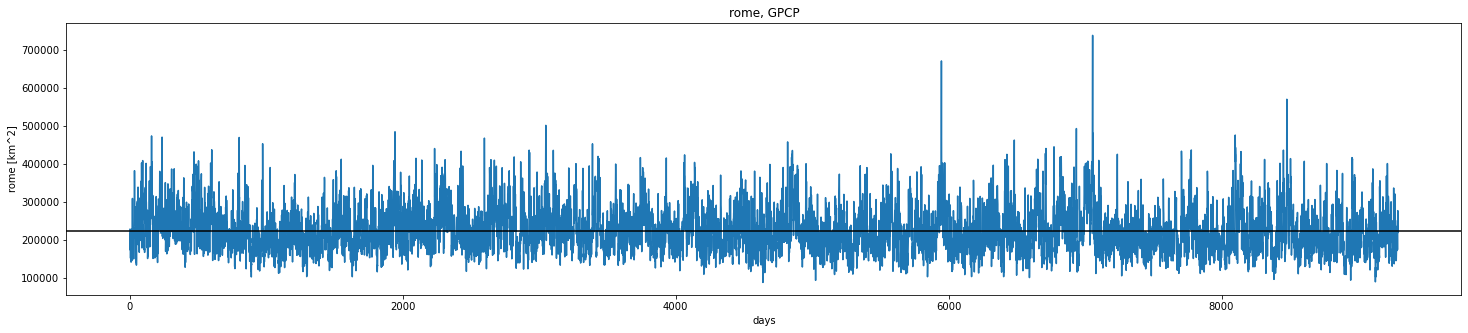

In [ ]:
f, ax = plt.subplots(figsize = (25,5))
ax.plot(rome)
ax.axhline(y=rome.mean(dim='time'), color='k')
ax.set_title(rome_option + ', model: ' + model + ', ' + experiment)
#ax.set_ylim(0,100)
ax.set_xlabel('days')
ax.set_ylabel(rome_option + ' [' + rome.units + ']')


if obs['GPCP']:
    f, ax = plt.subplots(figsize = (25,5))
    ax.plot(rome_gpcp)
    ax.axhline(y=rome_gpcp.mean(dim='time'), color='k')
    ax.set_title(rome_option + ', GPCP')
    #ax.set_ylim(0,100)
    ax.set_xlabel('days')
    ax.set_ylabel(rome_option + ' [' + rome.units + ']')

## other

### seasonally

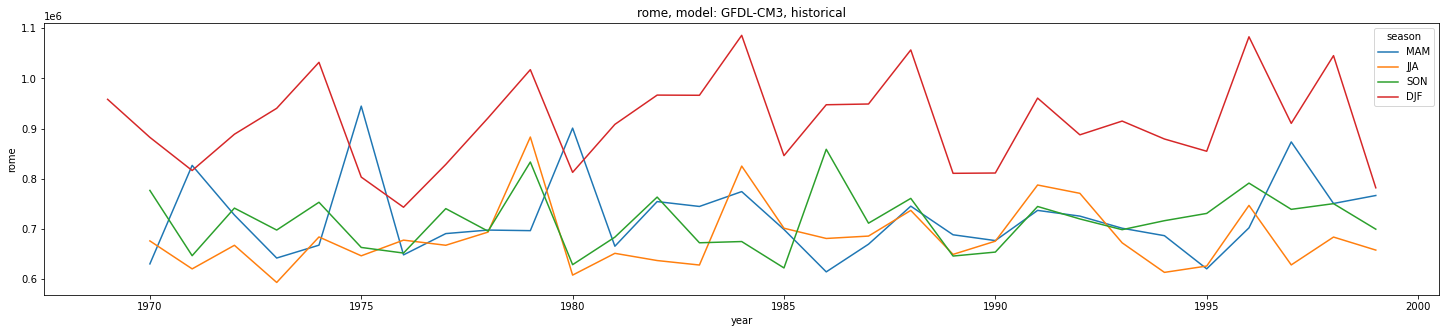

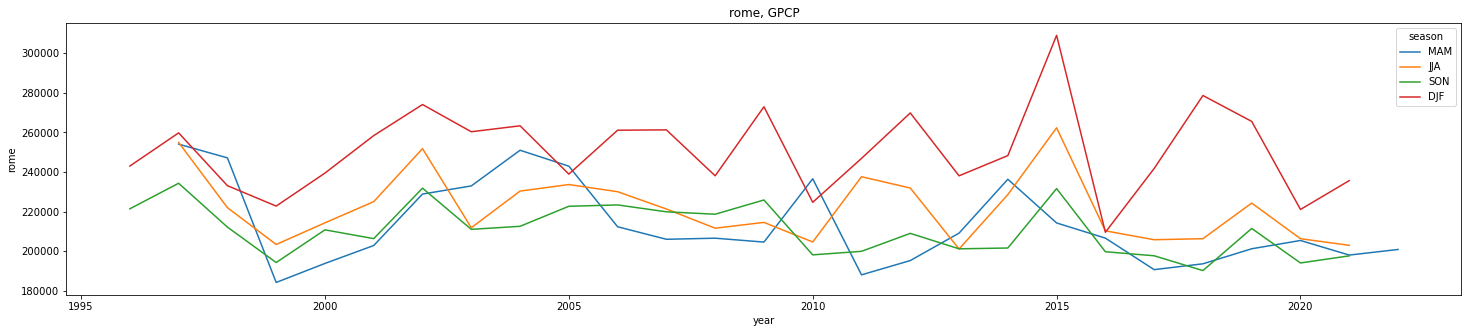

In [ ]:
season = rome.resample(time='QS-DEC').mean(dim="time")
season = to_monthly(season)
# 3 - MAM
# 6 - JJA
# 9 - SON
# 12 - DJF
season = season.rename({'month':'season'})
season = season.assign_coords(season = ["MAM", "JJA", "SON", "DJF"])
season.plot(x='year', hue='season', figsize=(25,5))
plt.title(rome_option + ', model: ' + model + ', ' + experiment)


if obs['GPCP']:
    season = rome_gpcp.resample(time='QS-DEC').mean(dim="time")
    season = to_monthly(season)
    # 3 - MAM
    # 6 - JJA
    # 9 - SON
    # 12 - DJF
    season = season.rename({'month':'season'})
    season = season.assign_coords(season = ["MAM", "JJA", "SON", "DJF"])
    season.plot(x='year', hue='season', figsize=(25,5))
    plt.title(rome_option + ', GPCP')